Done


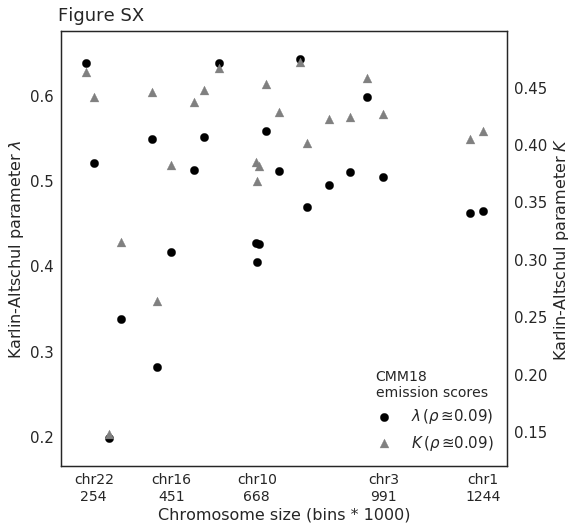

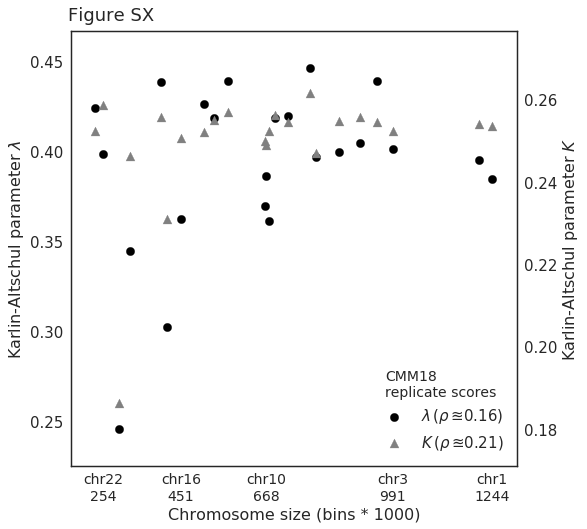

In [37]:
%matplotlib inline

import os as os
import collections as col
import itertools as itt
import pickle as pck
import time as ti

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import numpy as np
import numpy.random as rng
import scipy.stats as stats
import pandas as pd
import seaborn as sns

# What does this do?
# Plot several diagnostic plots
# that illustrate the adherence to
# the assumptions behind the
# Karlin-Altschul statistics

date = '20180604'

run_ka_size_corr = True

show_figures = True
save_figures = True

sns.set(style='white',
        font_scale=1.5,
        rc={'font.family': ['sans-serif'],
            'font.sans-serif': ['DejaVu Sans']})

np.seterr(all='raise')

scorings = ['emission', 'replicate']
resolution = {'lo': 150, 'hi': 350}
use_res = 'lo'

fhgfs_base = '/TL/deep/fhgfs/projects/pebert/thesis/projects/statediff'
cache_dir = os.path.join(fhgfs_base, 'caching/notebooks')

data_root = os.path.join(fhgfs_base, 'sciddo', 'deep')

base_out = '/TL/deep-external01/nobackup/pebert/cloudshare/mpiinf/phd/chapter_projects/statediff'
fig_supp = os.path.join(base_out, 'figures', 'pub', 'supp')
fig_main = os.path.join(base_out, 'figures', 'pub', 'main')
fig_collect = os.path.join(base_out, 'figures', 'pub', 'collection')


def plot_param_size_corr(metadata, scoring, segmentation):
    """
    """    
    fig, ax1 = plt.subplots(figsize=(8, 8))
    
    metadata.sort_values('size', ascending=True, inplace=True)
    x_ticklabels = [(row.size, row.Index) for row in metadata.itertuples()]
    
    x_ticks = []
    x_labels = []
    for idx, (num, chrom) in enumerate(x_ticklabels):
        if chrom in ['chr22', 'chr16', 'chr10', 'chr3', 'chr1']:
            x_labels.append('{}\n{}'.format(chrom, int(num // 1000)))
        else:
            x_labels.append('')
        x_ticks.append(num)   
    
    ax1_rho = np.round(stats.spearmanr(metadata['size'], metadata['ka_lambda'])[0], 2)
    
    ax1.scatter(metadata['size'].values,
                metadata['ka_lambda'].values,
                marker='o',
                color='black',
                s=70,
                label=r'$\lambda\/(\rho\/\approxeq' + str(ax1_rho) + ')$')
    ax1.set_ylabel('Karlin-Altschul parameter $\lambda$', fontsize=16)
    ax1.set_xlabel('Chromosome size (bins * 1000)', fontsize=16)
    
    #ax1.legend(loc=leg_loc1, fontsize=14)
    
    ax1_leg = ax1.scatter([], [],
                          marker='o', color='black', s=70,
                          label=r'$\lambda\/(\rho\/\approxeq' + str(ax1_rho) + ')$')
    
    ax1.set_xticks(x_ticks)
    ax1.set_xticklabels(x_labels, fontdict={'fontsize': 14})
    
    ax2 = ax1.twinx()
    
    ax2_rho = np.round(stats.spearmanr(metadata['size'], metadata['ka_k'])[0], 2)
    
    ax2.scatter(metadata['size'].values,
                metadata['ka_k'].values,
                marker='^',
                color='grey',
                s=80,
                label=r'$K\/(\rho\/\approxeq' + str(ax2_rho) + ')$')
    ax2.set_ylabel('Karlin-Altschul parameter $K$', fontsize=16)
    
    #ax2.legend(loc=leg_loc2, fontsize=14)
    
    ax2_leg = ax2.scatter([], [],
                          marker='^', color='grey', s=80,
                          label=r'$K\/(\rho\/\approxeq' + str(ax2_rho) + ')$')
    
    fig_leg = ax2.legend(handles=[ax1_leg, ax2_leg], loc='lower right',
                         title='{}\n{} scores'.format(segmentation.upper(), scoring))
    fig_leg.get_title().set_fontsize(14)
    
#     ax2.set_title('# variable bins vs. Karlin-Altschul parameters (Spearman\'s $\\rho$ ; ' + segmentation + ' ' + scoring + ' scoring)',
#                   fontsize=14)
    fig_tt = ax2.set_title('Figure SX', fontsize=18)
    fig_tt.set_position((0.09, 1.01))
    return fig, []

if run_ka_size_corr:
    datasets = []
    for root, dirs, files in os.walk(data_root):
        if files:
            for f in files:
                if f.endswith('score-chk'):
                    segmentation = f.split('.')[0].split('_')[-1]
                    data_file = f.replace('score-chk', 'h5')
                    datasets.append((os.path.join(root, data_file), segmentation))
    
    for fpath, seg in datasets:
        if seg != 'cmm18':
            continue
        with pd.HDFStore(fpath, 'r') as hdf:
            md_chrom = hdf['/metadata/chromosomes']
            for score in scorings:
                score_md = hdf['/scoring/{}/parameters'.format(score)]
                score_md.drop('genome', axis=0, inplace=True)
                score_md['size'] = md_chrom['bins']
                fig, exart = plot_param_size_corr(score_md, score, seg)
                if save_figures:
                    outname = 'fig_SX_param-corr_{}-{}'.format(seg, score)
                    
                    outpath = os.path.join(fig_supp, outname + '.pdf')
                    fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight')
                    
                    outpath = os.path.join(fig_supp, outname + '.png')
                    fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight', dpi=resolution[use_res])
                
    print('Done')